In [109]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib inline

import cv2
import glob
from IPython.display import Image
from sklearn import preprocessing

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [110]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import random
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))

    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    plt.plot(t['pred'].tolist(), label='Prediction', color='orange')
    plt.plot(t['y'].tolist(), label='Expected', color='blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)
    return df

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    


In [111]:
filename_read = os.path.join("data/HousesInfo.txt")
cols=["Bedrooms","Bathrooms","area","zipcode","price"]
df = pd.read_csv(filename_read , sep=" ", header=None , names=cols)
df.shape




(535, 5)

In [112]:
outlier= df.index[df['price'] <= 50000].tolist()
outlier1= df.index[df['price'] >= 900000].tolist()
outlier= outlier+outlier1
len(outlier)

83

In [113]:

df = df.loc[(df['price'] > 50000) & (df['price'] < 900000)]
df.head()
#sns.boxplot(x=df['price'])

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
6,3,4.0,2544,85262,799000
10,5,5.0,4829,85266,519200


In [114]:


missing_median(df,'Bedrooms')
missing_median(df,'Bathrooms')
missing_median(df,'area')
missing_median(df,'price')
df.shape

(452, 5)

In [115]:
## Bathroom.jpg
new_images=[]
for number in range(1, 536):
    for path in glob.glob("data/Houses dataset/" + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            new_images.append(path) 

In [116]:
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

In [117]:
## bedroom images
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob("data/Houses dataset/" + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path) 

In [118]:
img['bedroom_img']=bedroom_images

In [119]:
frontal_images = []
for number in range(1, 536):
    for path in glob.glob("data/Houses dataset/" + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path) 

In [120]:
img['frontal_img']=frontal_images

In [121]:
kitchen_images = []
for number in range(1, 536):
    for path in glob.glob("data/Houses dataset/" + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path) 

In [122]:
img['kitchen_img']=kitchen_images

In [123]:
img.head()

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,data/Houses dataset/1_bathroom.jpg,data/Houses dataset/1_bedroom.jpg,data/Houses dataset/1_frontal.jpg,data/Houses dataset/1_kitchen.jpg
1,data/Houses dataset/2_bathroom.jpg,data/Houses dataset/2_bedroom.jpg,data/Houses dataset/2_frontal.jpg,data/Houses dataset/2_kitchen.jpg
2,data/Houses dataset/3_bathroom.jpg,data/Houses dataset/3_bedroom.jpg,data/Houses dataset/3_frontal.jpg,data/Houses dataset/3_kitchen.jpg
3,data/Houses dataset/4_bathroom.jpg,data/Houses dataset/4_bedroom.jpg,data/Houses dataset/4_frontal.jpg,data/Houses dataset/4_kitchen.jpg
4,data/Houses dataset/5_bathroom.jpg,data/Houses dataset/5_bedroom.jpg,data/Houses dataset/5_frontal.jpg,data/Houses dataset/5_kitchen.jpg


In [124]:
img.shape

(535, 4)

In [125]:

img = img.drop(outlier)
img.shape

(452, 4)

In [126]:
#valid_indices = df.index

#df.reset_index(drop=True, inplace=True)  # Reset the index after filtering

# Filter the images_df based on the new indices of df
#filtered_images_df = img[img.index.isin(df.index)].reset_index(drop=True)

# At this point, df and filtered_images_df should have matching indices
#print("Filtered DataFrame:")
#print(df)

#print("\nFiltered Images DataFrame:")
#print(filtered_images_df)

In [127]:
images_output=[]

for row_index,row in img.iterrows():
            inputImages=[]
            outputImage = np.zeros((128, 128, 3), dtype="uint8")
            image_temp1 = cv2.imread(row.bathroom_img)
            image1 = cv2.resize(image_temp1, (64 , 64))
            
            image_temp2 = cv2.imread(row.bedroom_img)
            image2 = cv2.resize(image_temp2, (64 , 64))
            
            image_temp3 = cv2.imread(row.frontal_img)
            image3 = cv2.resize(image_temp3, (64 , 64))
            
            image_temp4 = cv2.imread(row.kitchen_img)
            image4 = cv2.resize(image_temp4, (64 , 64))
              
            inputImages.append(image1)
            inputImages.append(image2)
            inputImages.append(image3)
            inputImages.append(image4)
            
            outputImage[0:64, 0:64] = inputImages[0]
            outputImage[0:64, 64:128] = inputImages[1]
            outputImage[64:128, 64:128] = inputImages[2]
            outputImage[64:128, 0:64] = inputImages[3]
            
        
            images_output.append(outputImage)  
#img_arr = np.asarray(images_output)
#print("Shape of combined image array:", img_arr.shape)  # Should match the new number of rows in img

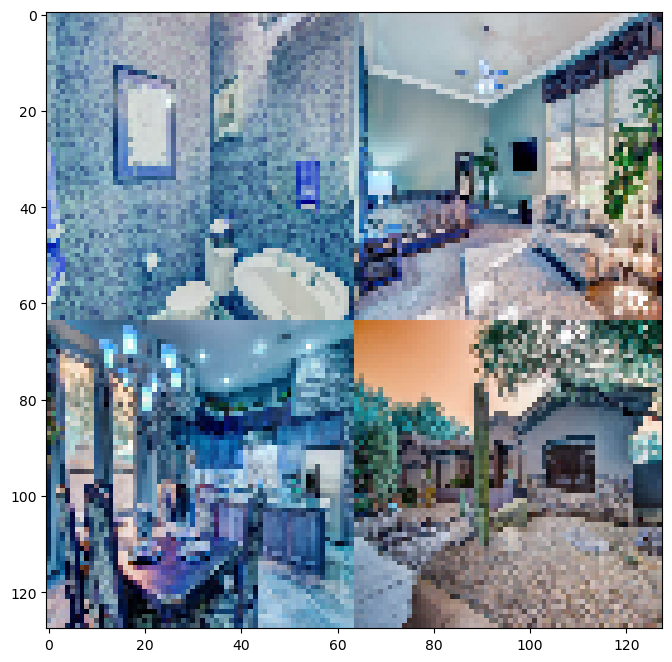

In [128]:
from matplotlib import pyplot as plt

for i in images_output[:1]:
     plt.figure(figsize=(8,8))
     plt.imshow(i, interpolation='nearest')
     plt.show()

In [129]:
len(images_output)

452

In [130]:

img_arr=np.asarray(images_output)
img_arr.shape

(452, 128, 128, 3)

## Next, using functional API, you create DENSE and CNN models to feed text and image to them seperately. 
### TensorFlow Functional API to extract visual, features from house photos and combining them with the house’s textual information
### a novel house price estimation system by using both textual and visual inputs

In [131]:
# Send the expected numeric and categorical columns to normalization. 
NumericColumns = ['area']
CategoricalColumns = ['zipcode','Bedrooms','Bathrooms']

for i in NumericColumns:
    encode_numeric_zscore(df,i)
for i in CategoricalColumns:
    encode_text_dummy(df,i)

df.head()

,area,price,zipcode-36372,zipcode-60002,zipcode-60016,zipcode-60046,zipcode-62025,zipcode-62034,zipcode-62088,zipcode-62214,...,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0
0,1.652649,869500,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,1.022859,865200,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,1.537335,889000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6,0.314122,799000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
10,2.340984,519200,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [132]:
df.shape

(452, 63)

In [133]:
x = df.drop(['price'], axis = 1)
y = df.loc[:, ['price']]

In [134]:
x

,area,zipcode-36372,zipcode-60002,zipcode-60016,zipcode-60046,zipcode-62025,zipcode-62034,zipcode-62088,zipcode-62214,zipcode-62234,...,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0
0,1.652649,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,1.022859,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,1.537335,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6,0.314122,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
10,2.340984,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,-0.109878,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
531,6.516230,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
532,-0.156003,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
533,0.108331,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [135]:
y

,price
0,869500
1,865200
2,889000
6,799000
10,519200
...,...
530,399900
531,460000
532,407000
533,419000


In [136]:
img_arr.shape


(452, 128, 128, 3)

In [137]:
# df = text table
# img_arr = images table
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [138]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(316, 62) (136, 62) (316, 1) (136, 1)


In [139]:
img_train, img_test = train_test_split(img_arr, test_size=0.30, random_state=42)
print(img_train.shape, img_test.shape)

(316, 128, 128, 3) (136, 128, 128, 3)


In [140]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
import pandas as pd
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate
from keras.models import Sequential
import cv2
from keras.preprocessing import sequence
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate
#FCNN for text table
input_dim = x_train.shape[1]
fcnn_input = Input(shape=(input_dim,))
fcnn_hidden1 = Dense(256, activation="relu")(fcnn_input)
fcnn_hidden2 = Dense(128, activation="relu")(fcnn_hidden1)
fcnn_hidden3 = Dense(64, activation="relu")(fcnn_hidden2)
fcnn_hidden4 = Dense(32, activation="relu")(fcnn_hidden3)
fcnn_output = Dense(1, activation="relu")(fcnn_hidden4)

#CNN for pic table
cnn_input = Input(shape=(128, 128, 3)) 
cnn_conv1 = Conv2D(32, kernel_size=4, activation='relu')(cnn_input)
cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
cnn_conv2 = Conv2D(16, kernel_size=4, activation='relu')(cnn_pool1)
cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
cnn_flat = Flatten()(cnn_pool2)

# merge input models
combined = concatenate([fcnn_output, cnn_flat])

#Interpret Model after concat
hidden1 = Dense(20, activation='relu')(combined)
hidden2 = Dense(10, activation='relu')(hidden1)
final_output = Dense(1, activation='relu')(hidden2)

model = Model(inputs=[fcnn_input, cnn_input], outputs=final_output)
# summarize layers
print(model.summary())

# plot model
plot_model(model,show_shapes=True)



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 62)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 dense_24 (Dense)               (None, 256)          16128       ['input_7[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 125, 125, 32  1568        ['input_8[0][0]']          

In [141]:
import tensorflow as tf
print(tf.__version__)


2.10.0


In [142]:
import numpy as np

# Convert arrays to float32 if they are not
x_train = np.array(x_train, dtype=np.float32)
#img_train = np.array(img_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
#img_test = np.array(img_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


In [143]:
#model.save("models/model.keras")
checkpoint = ModelCheckpoint(filepath="models/model.keras", verbose=1, save_best_only=True) # save best model 

for i in range(5):
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
    model.fit([x_train, img_train], y_train,batch_size=64,validation_data=([x_test, img_test], y_test),callbacks=[monitor],verbose=2,epochs=1000)
model.save("models/model.keras")
#model.load_weights('models/my_model.keras') 


Epoch 1/1000
5/5 - 2s - loss: 246882287616.0000 - val_loss: 259912941568.0000 - 2s/epoch - 386ms/step
Epoch 2/1000
5/5 - 1s - loss: 231955890176.0000 - val_loss: 225814036480.0000 - 914ms/epoch - 183ms/step
Epoch 3/1000
5/5 - 1s - loss: 179033554944.0000 - val_loss: 134227623936.0000 - 883ms/epoch - 177ms/step
Epoch 4/1000
5/5 - 1s - loss: 86846160896.0000 - val_loss: 58173616128.0000 - 831ms/epoch - 166ms/step
Epoch 5/1000
5/5 - 1s - loss: 73911902208.0000 - val_loss: 62230138880.0000 - 913ms/epoch - 183ms/step
Epoch 6/1000
5/5 - 1s - loss: 57180303360.0000 - val_loss: 60648738816.0000 - 966ms/epoch - 193ms/step
Epoch 7/1000
5/5 - 1s - loss: 59712765952.0000 - val_loss: 66462896128.0000 - 899ms/epoch - 180ms/step
Epoch 8/1000
5/5 - 1s - loss: 57918500864.0000 - val_loss: 56472059904.0000 - 840ms/epoch - 168ms/step
Epoch 9/1000
5/5 - 1s - loss: 55725428736.0000 - val_loss: 56387526656.0000 - 899ms/epoch - 180ms/step
Epoch 10/1000
5/5 - 1s - loss: 55543869440.0000 - val_loss: 5622285107

In [144]:
from sklearn import metrics

model_pred = model.predict([x_test,img_test])

score = np.sqrt(metrics.mean_squared_error(y_test,model_pred)) 

print("Score (RMSE) : {}".format(score))
print("R2 score     :",metrics.r2_score(y_test,model_pred))
print("MSE          :", metrics.mean_squared_error(y_test, model_pred))

5/5 [==============================] - 0s 19ms/step
Score (RMSE) : 124072.0546875
R2 score     : 0.7364984560125778
MSE          : 15393874000.0


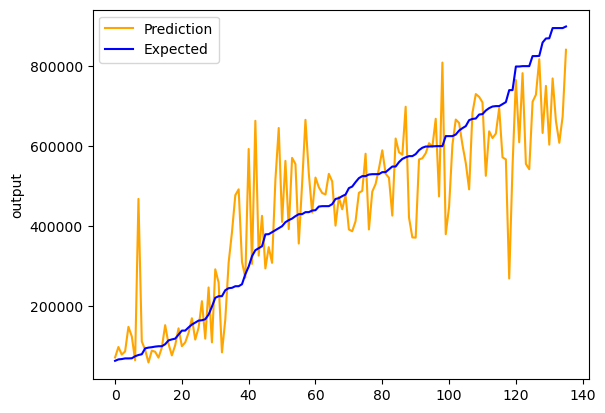

In [145]:
model_pred = np.asarray(model_pred)
y_test_NN = np.asarray(y_test)

chart_regression(model_pred.flatten(),y_test_NN)